## imports

In [ ]:
from tqdm import tqdm
import pickle
import torch

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## load data (logits from inference of original asr model)

In [ ]:
with open('/content/data (1).pkl', 'rb') as file:
    all_data = pickle.load(file)

In [ ]:
vocab = all_data["vocab"]
len(vocab)

28

In [ ]:
tags = all_data["tags"]

In [ ]:
from torch import nn
ctc_loss = nn.CTCLoss()

## some utils

In [ ]:
def is_valid_sentence(sentence: str) -> bool:
    is_valid = all([char.isalpha() or char == ' ' for char in sentence])
    return is_valid

In [ ]:
all_logtis = []
transcriptions = []

for tag in tags:
    transcription = tag["transcription"]
    if not is_valid_sentence(transcription):
        continue
    all_logtis.append(torch.tensor(tag["logits"]))
    transcriptions.append(transcription)

In [ ]:
max_length = max([t.shape[0] for t in all_logtis])
def pad_tensor(logprobs, to_size):
    to_pad = to_size - len(logprobs)
    return torch.vstack([logprobs,torch.zeros((to_pad,29))])

## simple model for comparison

In [ ]:
from torch import nn
import torch.nn.functional as F
features = len(vocab) + 1

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(
            in_features=features,
            out_features=features,
            bias=False
        )

    def forward(self, x):
        return self.fc(x)


## model with attention and lstm

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        attn_weights = torch.tanh(self.attn(encoder_outputs))
        attn_weights = torch.bmm(attn_weights, hidden.unsqueeze(2)).squeeze(2)
        attn_weights = F.softmax(attn_weights, dim=1)

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context, attn_weights

class AttentionCorrectionModel(nn.Module):
    def __init__(self):
        super(AttentionCorrectionModel, self).__init__()
        self.hidden_size = 64
        self.lstm = nn.LSTM(input_size=features, hidden_size=self.hidden_size, batch_first=True)
        self.attention = Attention(self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, features)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        context, _ = self.attention(hidden[-1], lstm_out)
        output = self.fc(context)
        output = output.unsqueeze(1).repeat(1, x.size(1), 1)

        return output


## data loader

In [ ]:
from torch.utils.data import Dataset, DataLoader


def pad_tensor(tensor, length, padding_value=0):
    # Check if the tensor is 1D or 2D
    if tensor.ndim == 1:
        padding_size = (length - tensor.size(0),)
        padding_tensor = torch.full(padding_size, padding_value)
        return torch.cat([tensor, padding_tensor], dim=0)
    elif tensor.ndim == 2:
        padding_size = (length - tensor.size(0), tensor.size(1))
        padding_tensor = torch.full(padding_size, padding_value)
        return torch.cat([tensor, padding_tensor], dim=0)
    else:
        raise ValueError("Unsupported tensor dimension for padding.")

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    max_x_length = max(x.size(0) for x in xx)
    max_y_length = max(y.size(0) for y in yy)

    xx_pad = [pad_tensor(x, max_x_length) for x in xx]
    yy_pad = [pad_tensor(y, max_y_length) for y in yy]

    xx_pad = torch.stack(xx_pad)
    yy_pad = torch.stack(yy_pad)

    return xx_pad, yy_pad


In [ ]:
def generate_data():

    X = [torch.log_softmax(logits_tensor, dim=1) for logits_tensor in all_logtis]

    y = []
    for transcription in transcriptions:
        indices = [vocab.index(token.lower()) for token in transcription]
        y.append(torch.tensor(indices))

    dataset = CustomDataset(X, y)

    # Create dataloader with custom collate function for padding
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=pad_collate)
    return dataloader


## train models using different hyperparams

In [ ]:
dataloader = generate_data()

def train_and_evaluate(model_idx: int, lr: int, wd: int, steps: int):
    model = models[model_idx]

    device = torch.device('cuda')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    for step in tqdm(range(steps)):
        for batch_X, batch_y in dataloader:

            batch_X = batch_X.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)

            outputs = outputs.permute(1, 0, 2)
            T, N, C = outputs.shape

            batch_X = batch_X.permute(1, 0, 2)
            batch_y = [y.to(device) for y in batch_y]  # Move each target to the GPU

            X_T, X_N, X_C = batch_X.shape

            # input_lengths should be a tensor with the length of each input in the batch (all equal in this case)
            input_lengths = torch.full(size=(X_N,), fill_value=X_T, dtype=torch.long).to(device)

             # y should be 1D tensor of target indices concatenated, batch_y already has this shape
            target_lengths = torch.tensor([len(y) for y in batch_y], dtype=torch.long).to(device)
            batch_y = torch.cat(batch_y).to(device)  # Actual lengths of target sequences

            loss = ctc_loss(
                outputs,
                batch_y,
                input_lengths,
                target_lengths
            )

            loss.backward()
            optimizer.step()

    return loss.item()

In [ ]:
import itertools

learning_rates = [1e-3, 1e-4, 1e-5]
weight_decays = [0, 1e-4, 1e-2]
steps_options = [100, 300, 500]


# Generate all combinations for Grid Search
combinations = list(itertools.product(learning_rates, weight_decays, steps_options))

In [ ]:
#models = [SimpleModel() for _ in range(len(combinations))]
models = [AttentionCorrectionModel() for _ in range(len(combinations))]

In [ ]:
# model_idx = 0
# for lr, wd, steps in combinations:
#     print(f"Training with lr={lr}, wd={wd}, steps={steps}...")
#     current_loss = train_and_evaluate(model_idx, lr, wd, steps)
#     model_idx += 1
#     print(current_loss)
loss = train_and_evaluate(3, 1e-3, 1e-4, 100) # model number three

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


In [ ]:
for i, model in enumerate(models):
  torch.save(model.state_dict(), f'model_weights_{i}.pth')

In [ ]:
[torch.argmax(models[-1].fc.weight[i]) for i in range(29)]

[tensor(28, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(6, device='cuda:0'),
 tensor(7, device='cuda:0'),
 tensor(8, device='cuda:0'),
 tensor(9, device='cuda:0'),
 tensor(10, device='cuda:0'),
 tensor(11, device='cuda:0'),
 tensor(12, device='cuda:0'),
 tensor(13, device='cuda:0'),
 tensor(14, device='cuda:0'),
 tensor(15, device='cuda:0'),
 tensor(16, device='cuda:0'),
 tensor(17, device='cuda:0'),
 tensor(18, device='cuda:0'),
 tensor(19, device='cuda:0'),
 tensor(20, device='cuda:0'),
 tensor(21, device='cuda:0'),
 tensor(22, device='cuda:0'),
 tensor(23, device='cuda:0'),
 tensor(28, device='cuda:0'),
 tensor(25, device='cuda:0'),
 tensor(28, device='cuda:0'),
 tensor(28, device='cuda:0'),
 tensor(17, device='cuda:0')]

In [ ]:
torch.save(models[-1].state_dict(), 'model_weights.pth')

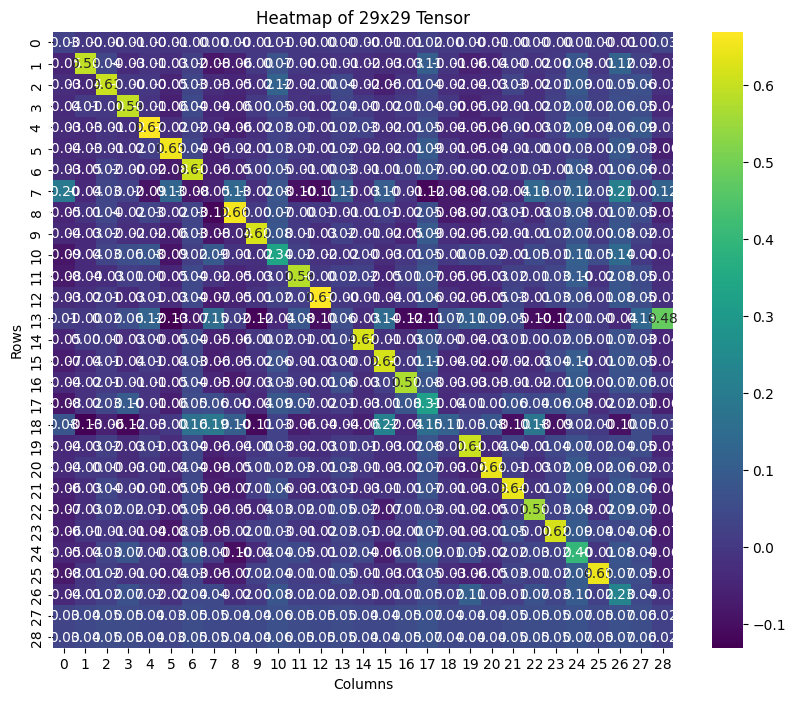

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert tensor to numpy array
tensor_np = models[7].fc.weight.detach().cpu().numpy()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tensor_np, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Heatmap of 29x29 Tensor')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()


In [ ]:
def eval_wer_cer(gt_char,pred_char):
  cer = editdistance.distance(gt_char,pred_char)/len(gt_char)
  gt = gt_char.split(' ')
  pred = pred_char.split(' ')
  wer = editdistance.distance(gt,pred)/len(gt)
  return wer,cer